In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

'''install extra modeules if needed'''
# !pip install xgboost
from xgboost import XGBClassifier
# !pip install lightgbm
# !pip install catboost
import lightgbm as lgb
import catboost as cb
# !pip install rgf_python
from rgf.sklearn import RGFClassifier, FastRGFClassifier

# import functions from scripts
import sys
path = os.getcwd()
sys.path.append(path+'/scripts')
import param_grids
from make_model_3 import make_model_l, make_model_nl

In [4]:
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [9]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_copy = df.copy()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


### Decision Trees

- Use Dt algorithms to predict, find optimal hyperparameters.
- Update hyperparameters in param_grids.py or manually in this notebook
- Compare Decision Tree model with ensemble models using DecisionTreeClassifier

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 100}
Accuracy : 0.9355939363776962
Training Time : 4 minutes
Test Score : 0.9369769657330773


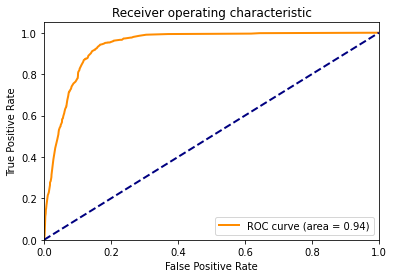

In [11]:
random_state = 42
folds = 5
model_name = f'new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

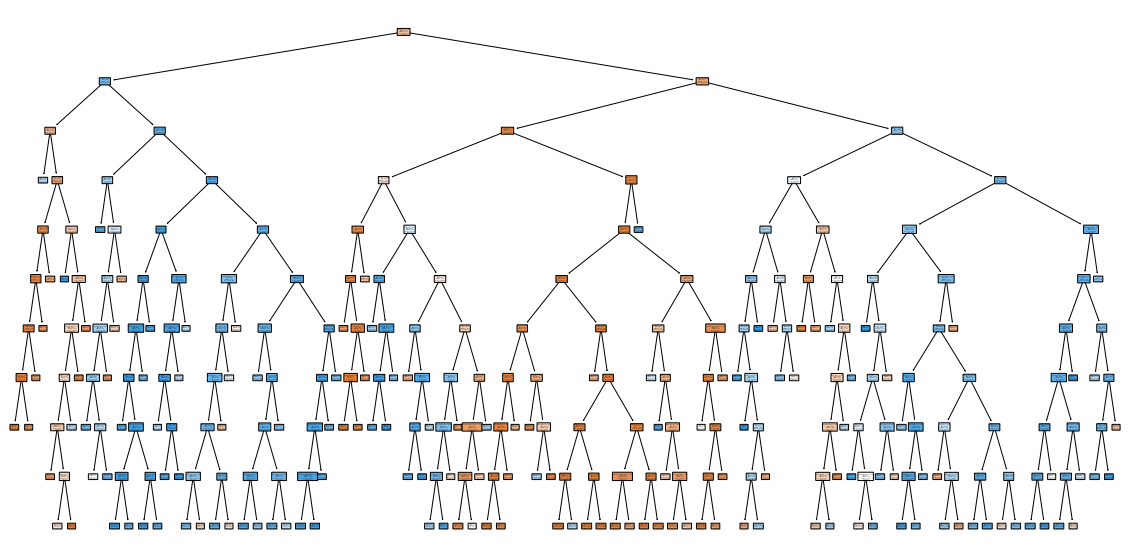

In [14]:
from sklearn.tree import plot_tree

random_state = 42
folds = 5
# Load the trained model from disk
model_name = f'new_dt_{folds}'
loaded_model = pickle.load(open(f'trained_models/{model_name}.pkl', 'rb'))

# Get the best estimator (trained decision tree) from the GridSearchCV object
best_tree = loaded_model.best_estimator_.named_steps['classifier']

# Encode df with the same encoder as used in the training
df = df_copy.copy()
X=df.drop('y', axis=1)
# Create a pipeline for categorical features
cat_features = X.select_dtypes(include=['object']).columns
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Create a pipeline for numerical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# Create a column transformer
preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('num', num_pipeline, num_features)
])
df_encoded = preprocessor.fit_transform(X)
feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(cat_features).tolist() + num_features.tolist()
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=feature_names, class_names=['no', 'yes'], filled=True, rounded=True)
plt.show()


### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Accuracy : 0.9438728006148438
Training Time : 1 minutes
Test Score : 0.9424278792467531


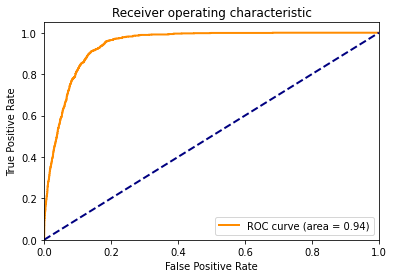

In [12]:
random_state = 42
folds = 5
model_name = f'new_rf_{folds}'
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_rf

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### AdaBoost

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=1), 'classifier__n_estimators': 300}
Accuracy : 0.9396568245053366
Training Time : 3 minutes
Test Score : 0.9402804942075668


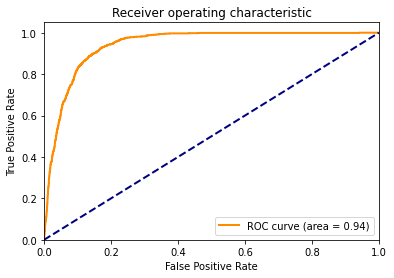

In [13]:
random_state = 42
folds = 5
model_name = f'new_ada_{folds}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### XGBoost

[13:07:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[13:07:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[13:07:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[13:07:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[13:07:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[13:07:14] WARNING: /Users/runner/work/x

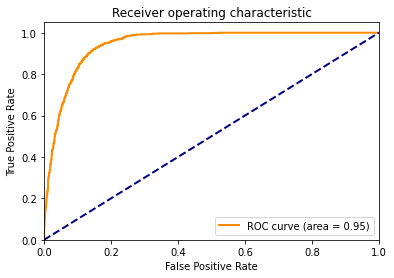

In [10]:
reload(param_grids)
random_state = 42
folds = 5

model_name = f'new_xgb_{folds}'
model = XGBClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_xgb  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

warnings.filterwarnings("ignore", message=".*Parameters: { \"gamma\", \"max_depth\" } are not used.*")

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Bagging

Tuned Hyperparameters : {'classifier__base_estimator': LogisticRegression(C=1, solver='liblinear'), 'classifier__n_estimators': 300}
Accuracy : 0.936256610066798
Training Time : 1 minutes
Test Score : 0.9370338612583944


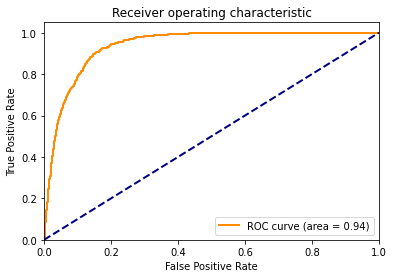

In [15]:
random_state = 42
folds = 5

model_name = f'new_bag_{folds}'
model = BaggingClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_bag  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


- BaggingClassifier gives better estimates when using LogisticRegression as base estimator.

### LightGBM

Tuned Hyperparameters : {'classifier__boosting_type': 'dart', 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 0.001}
Accuracy : 0.9496452211977132
Training Time : 3 minutes
Test Score : 0.9492728429676178


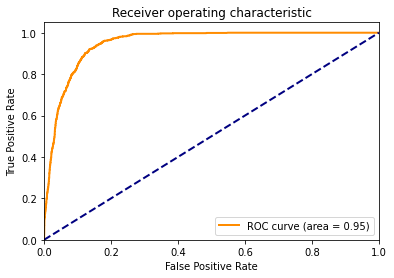

In [16]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_lgbm_{folds}'
model = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_lgbm  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### CatBoost

Tuned Hyperparameters : {'classifier__bootstrap_type': 'Bernoulli', 'classifier__depth': 6, 'classifier__l2_leaf_reg': 5}
Accuracy : 0.9490101425690955
Training Time : 25 minutes
Test Score : 0.949314507773159


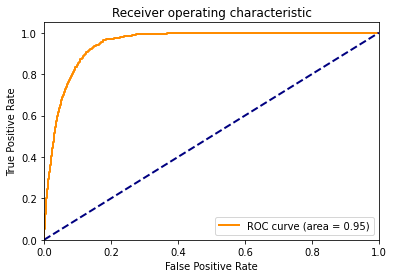

In [17]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_catboost_{folds}'
model = cb.CatBoostClassifier(random_state=random_state, silent=True)
parameters = param_grids.param_cat

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Extra Trees

Tuned Hyperparameters : {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.9276952425515832
Training Time : 31 minutes
Test Score : 0.9261904674732602


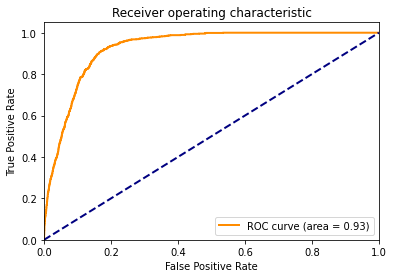

In [22]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_extra_{folds}'
model = ExtraTreesClassifier(n_jobs=-1, random_state=random_state)
parameters = param_grids.param_extra

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Regulaized Greedy Forest

In [28]:
# reload(param_grids)

# random_state = 42
# folds = 5

# model_name = f'new_rgf_{folds}'
# model = RGFClassifier(n_jobs=-1)
# parameters = param_grids.param_rgf

# df = df_copy.copy()

# clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

# pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

# output_file = f'trained_models/{model_name}.txt'

# with open(output_file, 'w') as f:
#     # Write the tuned hyperparameters and accuracy to file
#     f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
#     f.write(f"Accuracy: {clf_grid.best_score_}\n")
#     # Write training time in minutes to file
#     f.write(f"Training Time: {time} minutes\n")
#     f.write(f"Test Score: {test_score}\n")


Tuned Hyperparameters : {'classifier__algorithm': 'RGF', 'classifier__max_leaf': 1000}
Accuracy : nan
Training Time : 7 minutes


IndexError: index 0 is out of bounds for axis 0 with size 0

# Compare models 

### Define tuned hyperparameters

In [36]:
param_dt = {
    'classifier__max_depth' : [10],
    'classifier__min_samples_split' : [100],
    'classifier__min_samples_leaf'  : [15],
}
param_rf = {
    'classifier__max_depth'    : [10],
    'classifier__min_samples_split' : [5],
    'classifier__min_samples_leaf'  : [1],
}
param_ada = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}   
param_xgb = {
    'classifier__max_depth' : [6],
     'classifier__gamma' : [0.2],
    'classifier__eval_metric' : ['auc'],
    'classifier__booster' : ['gbtree'],
}
param_bag = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}
param_lgbm = {
    'classifier__n_estimators': [300],
    'classifier__boosting_type': ['dart'],
    'classifier__reg_alpha' : [1.0],
    'classifier__reg_lambda' : [0.001],
}
param_cat = {
    'classifier__depth': [6],
    'classifier__l2_leaf_reg': [5],
    'classifier__bootstrap_type': ['Bernoulli'],
}  
param_extra = {
    'classifier__class_weight': [None], 
    'classifier__max_depth': [None], 
    'classifier__max_features': ['sqrt'], 
    'classifier__min_samples_leaf': [1], 
    'classifier__min_samples_split': [10], 
    'classifier__n_estimators': [300]
}
param_rgf = {
    'classifier__algorithm': 'RGF', 
    'classifier__max_leaf': [1000]
}

Training DecisionTree...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9365354216979777
Training Time : 0 minutes
Test Score : 0.9362335894486259


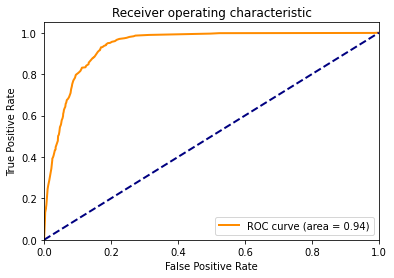

Confusion Matrix:
[[6489  814]
 [ 164  771]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7303
           1       0.49      0.82      0.61       935

    accuracy                           0.88      8238
   macro avg       0.73      0.86      0.77      8238
weighted avg       0.92      0.88      0.89      8238

Training RandomForest...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Accuracy : 0.9405002273823755
Training Time : 0 minutes
Test Score : 0.9384551510221057


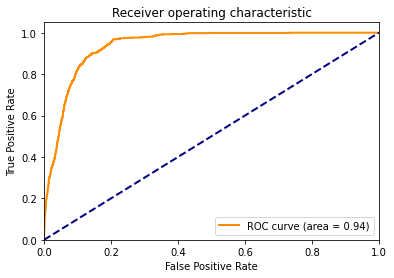

Confusion Matrix:
[[6593  710]
 [ 174  761]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7303
           1       0.52      0.81      0.63       935

    accuracy                           0.89      8238
   macro avg       0.75      0.86      0.78      8238
weighted avg       0.92      0.89      0.90      8238

Training AdaBoost...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.9312476912786458
Training Time : 1 minutes
Test Score : 0.9369199237585316


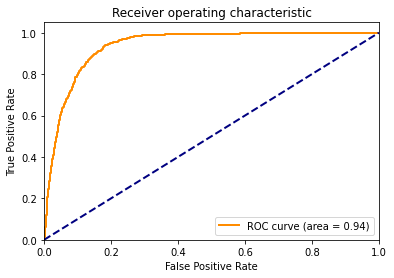

Confusion Matrix:
[[6674  629]
 [ 242  693]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.52      0.74      0.61       935

    accuracy                           0.89      8238
   macro avg       0.74      0.83      0.78      8238
weighted avg       0.91      0.89      0.90      8238

Training XGBoost...
Tuned Hyperparameters : {'classifier__booster': 'gbtree', 'classifier__eval_metric': 'auc', 'classifier__gamma': 0.2, 'classifier__max_depth': 6}
Accuracy : 0.9448668226848932
Training Time : 0 minutes
Test Score : 0.9441622774612441


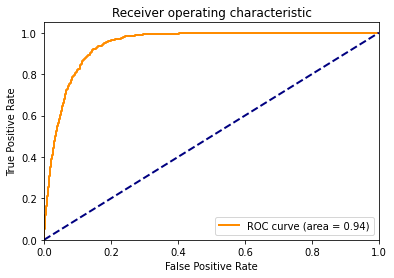

Confusion Matrix:
[[6673  630]
 [ 197  738]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.54      0.79      0.64       935

    accuracy                           0.90      8238
   macro avg       0.76      0.85      0.79      8238
weighted avg       0.92      0.90      0.91      8238

Training BaggingClassifier...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.8946694003311869
Training Time : 0 minutes
Test Score : 0.9016446248373498


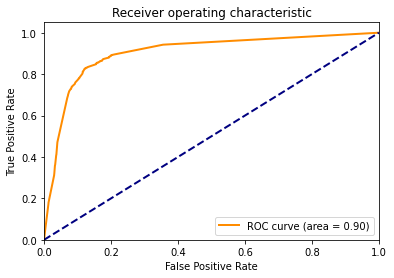

Confusion Matrix:
[[6414  889]
 [ 163  772]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92      7303
           1       0.46      0.83      0.59       935

    accuracy                           0.87      8238
   macro avg       0.72      0.85      0.76      8238
weighted avg       0.92      0.87      0.89      8238

Training LGBMClassifier...
Tuned Hyperparameters : {'classifier__boosting_type': 'dart', 'classifier__n_estimators': 300, 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 0.001}
Accuracy : 0.9490096811132347
Training Time : 0 minutes
Test Score : 0.9491286637020462


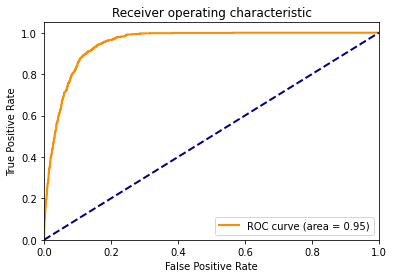

Confusion Matrix:
[[6586  717]
 [ 150  785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7303
           1       0.52      0.84      0.64       935

    accuracy                           0.89      8238
   macro avg       0.75      0.87      0.79      8238
weighted avg       0.93      0.89      0.90      8238

Training CatBoostClassifier...
Tuned Hyperparameters : {'classifier__bootstrap_type': 'Bernoulli', 'classifier__depth': 6, 'classifier__l2_leaf_reg': 5}
Accuracy : 0.9480851081502566
Training Time : 1 minutes
Test Score : 0.9488987384131201


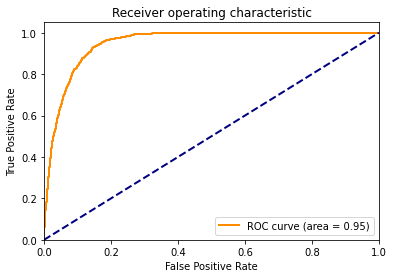

Confusion Matrix:
[[6657  646]
 [ 172  763]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.54      0.82      0.65       935

    accuracy                           0.90      8238
   macro avg       0.76      0.86      0.80      8238
weighted avg       0.93      0.90      0.91      8238

Training ExtraTreesClassifier...
Tuned Hyperparameters : {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.9268697903075349
Training Time : 0 minutes
Test Score : 0.9245946102290392


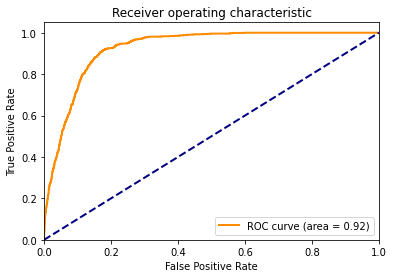

Confusion Matrix:
[[6703  600]
 [ 326  609]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7303
           1       0.50      0.65      0.57       935

    accuracy                           0.89      8238
   macro avg       0.73      0.78      0.75      8238
weighted avg       0.90      0.89      0.89      8238



,Model,Training Time (min),Test Score,Best Hyperparameters
0,DecisionTree,0.03,0.94,"{'classifier__max_depth': 10, 'classifier__min..."
1,RandomForest,0.07,0.94,"{'classifier__max_depth': 10, 'classifier__min..."
2,AdaBoost,0.60,0.94,{'classifier__base_estimator': DecisionTreeCla...
3,XGBoost,0.17,0.94,"{'classifier__booster': 'gbtree', 'classifier_..."
4,BaggingClassifier,0.16,0.90,{'classifier__base_estimator': DecisionTreeCla...
5,LGBMClassifier,0.32,0.95,"{'classifier__boosting_type': 'dart', 'classif..."
6,CatBoostClassifier,0.61,0.95,"{'classifier__bootstrap_type': 'Bernoulli', 'c..."
7,ExtraTreesClassifier,0.17,0.92,"{'classifier__class_weight': None, 'classifier..."


,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC,MCC,Log-Loss
0,DecisionTree,0.88,0.49,0.82,0.61,0.94,0.57,4.10
1,RandomForest,0.89,0.52,0.81,0.63,0.94,0.59,3.71
2,AdaBoost,0.89,0.52,0.74,0.61,0.94,0.57,3.65
3,XGBoost,0.90,0.54,0.79,0.64,0.94,0.60,3.47
4,BaggingClassifier,0.87,0.46,0.83,0.59,0.90,0.56,4.41
5,LGBMClassifier,0.89,0.52,0.84,0.64,0.95,0.61,3.64
6,CatBoostClassifier,0.90,0.54,0.82,0.65,0.95,0.61,3.43
7,ExtraTreesClassifier,0.89,0.50,0.65,0.57,0.92,0.51,3.88


In [35]:
import make_model_5
reload(make_model_5)
from make_model_5 import make_model

random_state = 42
folds = 5

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=random_state),
    'RandomForest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(random_state=random_state, n_jobs=-1),
    'LGBMClassifier': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1),
    'CatBoostClassifier': cb.CatBoostClassifier(random_state=random_state, silent=True),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=random_state, n_jobs=-1),
    'RGFClassifier': RGFClassifier(),
}

parameters = {
    'DecisionTree': param_dt,
    'RandomForest': param_rf,
    'AdaBoost': param_ada,
    'XGBoost': param_xgb,
    'BaggingClassifier': param_bag,
    'LGBMClassifier': param_lgbm,
    'CatBoostClassifier': param_cat,
    'ExtraTreesClassifier': param_extra,
    'RGFClassifier': param_rgf,
}

results = []
metrics_list = []
df = df_orig.copy()
for model_name, model in models.items():
    print(f"Training {model_name}...")
    clf_grid, time, test_score, metrics_df = make_model(df, model, parameters[model_name], test_size=0.2, folds=folds)
    
    # Save the model to disk
    pickle.dump(clf_grid, open(f'trained_models/tuned_{model_name}.pkl', 'wb'))

    results.append({
        'Model': model_name,
        'Training Time (min)': time,
        'Test Score': test_score,
        'Best Hyperparameters': clf_grid.best_params_
    })

    metrics_df['Model'] = model_name
    metrics_list.append(metrics_df)

# Convert results to a pandas DataFrame and display the table
results_df = pd.DataFrame(results)
display(results_df)

# Concatenate metrics DataFrames and display the table
all_metrics_df = pd.concat(metrics_list, ignore_index=True)
all_metrics_df.insert(0, 'Model', all_metrics_df.pop('Model'))
display(all_metrics_df)

When dealing with heavily imbalanced datasets, it is crucial to choose evaluation metrics that can effectively capture the performance of your model, especially in terms of identifying the minority class. Traditional metrics like accuracy can be misleading, as they may not account for the imbalance between classes. In such cases, the following metrics are generally more appropriate:

- Precision: The proportion of true positive predictions out of all positive predictions made. In imbalanced datasets, precision helps to assess how well the model identifies the minority class without being affected by the overwhelming majority class.
- Recall (Sensitivity): The proportion of true positive predictions out of all actual positive instances. Recall is essential in imbalanced datasets because it indicates the model's ability to capture the minority class instances, even if they are scarce.
- F1-score: The harmonic mean of precision and recall. F1-score balances both precision and recall and is particularly useful when there is class imbalance, as it helps to account for both false positives and false negatives, providing a more comprehensive measure of model performance.
- Area Under the ROC Curve (AUC-ROC): A measure of the classifier's ability to distinguish between positive and negative instances across different decision thresholds. AUC-ROC is useful in imbalanced datasets because it is less sensitive to class distribution and considers the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various thresholds.
- Area Under the Precision-Recall Curve (AUC-PR): A measure of the classifier's ability to distinguish between positive and negative instances while taking into account both precision and recall. AUC-PR is particularly useful for imbalanced datasets, as it focuses on the performance of the model in identifying the minority class, emphasizing the relationship between precision and recall.

In summary, when dealing with heavily imbalanced datasets, it is essential to select evaluation metrics that focus on the model's performance in identifying the minority class. Precision, recall, F1-score, AUC-ROC, and AUC-PR are among the most suitable metrics for such cases.

Accuracy might be misleading when dealing with imbalanced datasets because it measures the proportion of correctly classified instances out of the total instances, without considering the class distribution. In a heavily imbalanced dataset, a model can achieve a high accuracy simply by predicting the majority class for all instances, without effectively identifying the minority class instances. This high accuracy gives a false impression of good performance, even though the model is not actually capturing the patterns and characteristics of the minority class, which is often the class of interest. Thus, relying on accuracy alone in imbalanced scenarios can lead to misleading evaluations and suboptimal models that fail to address the underlying problem.

Balanced Accuracy is a performance metric used to evaluate the performance of classification models, especially when dealing with imbalanced datasets. It is the average of recall (sensitivity) scores for each class. In a binary classification setting, the balanced accuracy is defined as:

Balanced Accuracy = (Sensitivity + Specificity) / 2

Where:

- Sensitivity (or True Positive Rate) is the proportion of true positive instances among the actual positive instances.
- Specificity (or True Negative Rate) is the proportion of true negative instances among the actual negative instances.

Balanced Accuracy takes into account both false positives and false negatives, making it a more informative metric when dealing with imbalanced datasets. 

### Shortcut with LazyPredict

In [31]:
import lazypredict
import sklearn
from lazypredict.Supervised import LazyClassifier

models_to_exclude = [('LabelPropagation',
  sklearn.semi_supervised._label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading)]  # These models take too long to train, can also exclude svc

lazypredict.Supervised.CLASSIFIERS = [x for x in lazypredict.Supervised.CLASSIFIERS if x not in models_to_exclude]
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('LinearSVC', sklearn.svm._classes.LinearSVC),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('NearestCentroid', sklearn.neighbors._nearest_cen

In [36]:
df = df_copy.copy()
y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Convert models dictionary to a DataFrame
# df_models = pd.DataFrame(models.items(), columns=['Model', 'Accuracy'])
df_models = pd.DataFrame(models)

# Save DataFrame to text file
df_models.to_csv('lazy_predict_results.txt', sep='\t', index=False)

# Print DataFrame
print(df_models)

100%|██████████| 27/27 [00:45<00:00,  1.68s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.77               0.75    None      0.81   
LGBMClassifier                     0.92               0.75    None      0.91   
GaussianNB                         0.82               0.73    None      0.84   
DecisionTreeClassifier             0.89               0.73    None      0.89   
BernoulliNB                        0.81               0.73    None      0.84   
LinearDiscriminantAnalysis         0.91               0.73    None      0.90   
RandomForestClassifier             0.91               0.72    None      0.90   
BaggingClassifier                  0.90               0.72    None      0.90   
Perceptron                         0.88               0.70    None      0.88   
LogisticRegression                 0.91               0.69    None      0.89   
CalibratedClassifierCV             0.90 

In [37]:
df_models = pd.DataFrame(models)
df_models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.77,0.75,None,0.81,0.19
LGBMClassifier,0.92,0.75,None,0.91,0.38
GaussianNB,0.82,0.73,None,0.84,0.20
DecisionTreeClassifier,0.89,0.73,None,0.89,0.37
BernoulliNB,0.81,0.73,None,0.84,0.24
LinearDiscriminantAnalysis,0.91,0.73,None,0.90,0.55
RandomForestClassifier,0.91,0.72,None,0.90,2.50
BaggingClassifier,0.90,0.72,None,0.90,1.32
Perceptron,0.88,0.70,None,0.88,0.25
